In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [4]:
torch.__version__

'0.4.0'

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
device = torch.device('cuda:7' if USE_CUDA else 'cpu')

In [7]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [8]:
batch_size = 100

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [10]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [11]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [12]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [13]:
np.max(train_dataset_labelled)

255

In [14]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [15]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**WAE-WGAN**

In [16]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [17]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [18]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2] # [3 x 32 x 32]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, 4, padding=2, stride=2), # [128 x 17 x 17]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 9 x 9]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 5 x 5]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 5, padding=2, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3),
            nn.Linear(1024 * 3 * 3, output_dim) # [output_dim]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(mean=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, hidden_count=4):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            ReshapeLayer(-1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [20]:
class WAE_WGAN(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        self.proposal_discriminator = Discriminator(latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            ReshapeLayer(1024, 4, 4), # [1024 x 4 x 4]
            nn.ConvTranspose2d(1024, 512, 5, padding=1, stride=2), # [512 x 9 x 9]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 17 x 17]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=2, stride=2), # [128 x 32 x 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 3, 1), # [3 x 32 x 32]
            #nn.Sigmoid()
        )

    def prior_distr(self, n):
        mu = torch.zeros(n, self.latent_dim, device=device)
        sigma = torch.ones(n, self.latent_dim, device=device)
        return mu, sigma

    def sample_latent(self, X):
        return self.proposal_generator(X)

    def sample_prior(self, num_samples):
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        return self.generative_network(z)

    def batch_loss(self, X, 
                   return_reconstruction_loss=True, return_discriminator_loss=True, return_lipschitz_loss=True):
        n = X.shape[0]
        Z = self.sample_latent(X)
        Z_prior = self.sample_prior(n)
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        if return_discriminator_loss:
            discriminator_loss = torch.mean(self.proposal_discriminator(Z_prior) - self.proposal_discriminator(Z))
        else:
            discriminator_loss = None
        if return_lipschitz_loss:
            eps = torch.rand(n, 1, device=device)
            Z_hat = (Z_prior.detach() * eps + Z.detach() * (1 - eps)).requires_grad_()
            value_hat = self.proposal_discriminator(Z_hat)
            value_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_hat)], [Z_hat], create_graph=True)[0].view(n, -1) ** 2, dim=-1
            )
            lipschitz_loss = torch.mean((torch.sqrt(value_hat_grad_sqr_norm) - 1) ** 2)
        else:
            lipschitz_loss = None
        return reconstruction_loss, discriminator_loss, lipschitz_loss

    def generate_samples(self, num_samples):
        return self.generative_distr(self.sample_prior(num_samples))

In [21]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].to(torch.device('cpu')).numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

In [22]:
latent_dim = 64

num_epochs = 100
save_every = 10

name_prefix = 'wae_gan_results/'

try:
#if True:
    wae = WAE_WGAN(input_shape, latent_dim).to(device)
    wae.load_state_dict(torch.load(name_prefix + 'wae_gan.pt'))
    print("Found pretrained WAE-GAN")
except:
    print("Didn't found pretrained WAE-GAN; training...")
    
    wae = WAE_WGAN(input_shape, latent_dim).to(device)
    optimizer = optim.Adam(
        list(wae.proposal_generator.parameters()) + list(wae.generative_network.parameters()), 
        lr=3e-4, betas=(0.5, 0.999)
    )
    optimizer_discriminator = optim.Adam(wae.proposal_discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )
    scheduler_discriminator = optim.lr_scheduler.LambdaLR(
        optimizer_discriminator, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
        
        scheduler.step()
        scheduler_discriminator.step()
        
        regularization_factor = 10
        lipschitz_contraint_factor = 2
        update_generator_every = 2
        
        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            do_discriminator_update = (
                epoch * len(train_loader.dataset.train_labels) // X_batch.shape[0] + batch_count
            ) % update_generator_every > 0
        
            if do_discriminator_update:
                _, loss_discriminator, loss_lipschitz = wae.batch_loss(X_batch, return_reconstruction_loss=False)
                cum_loss_discriminator += loss_discriminator.item()
                cum_loss_lipschitz += loss_lipschitz.item()
                
                optimizer_discriminator.zero_grad()
                (loss_discriminator + loss_lipschitz * lipschitz_contraint_factor).backward()
                optimizer_discriminator.step()
            else:
                loss_reconstruction, loss_discriminator, _ = wae.batch_loss(X_batch, return_lipschitz_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_discriminator += loss_discriminator.item()
                
                optimizer.zero_grad()
                (loss_reconstruction - loss_discriminator * regularization_factor).backward()
                optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / (batch_count / update_generator_every)
        mean_train_loss_discriminator = cum_loss_discriminator / batch_count
        mean_train_loss_lipschitz = cum_loss_lipschitz / \
                                    ((update_generator_every - 1) * batch_count / update_generator_every)

        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, loss_discriminator, _ = wae.batch_loss(X_batch, return_lipschitz_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_discriminator += loss_discriminator.item()
                #cum_loss_lipschitz += loss_lipschitz.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_discriminator = cum_loss_discriminator / batch_count
        mean_test_loss_lipschitz = cum_loss_lipschitz / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train discriminator loss: {:.2f}; test discriminator loss: {:.2f}'.format(
            mean_train_loss_discriminator, mean_test_loss_discriminator
        ))
        print('train lipschitz loss: {:.2f}; test lipschitz loss: {:.2f}'.format(
            mean_train_loss_lipschitz, mean_test_loss_lipschitz
        ))
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(train_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                wae.generative_network(
                    wae.proposal_generator(X_batch)
                )
            )
            plt.show()
            show_images(wae.generate_samples(10))
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(wae.state_dict(), name_prefix + 'wae_gan.pt')
        
    print()


Found pretrained WAE-GAN


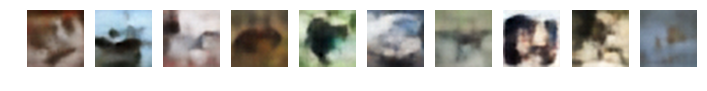

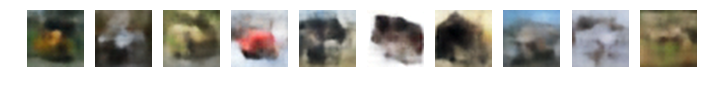

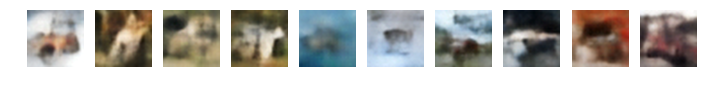

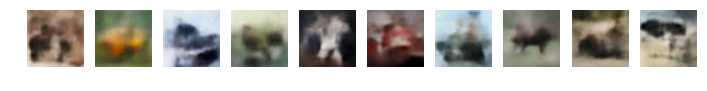

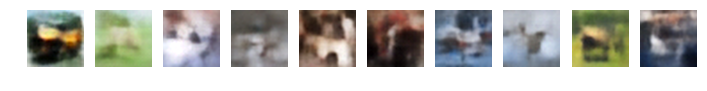

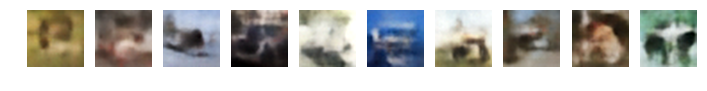

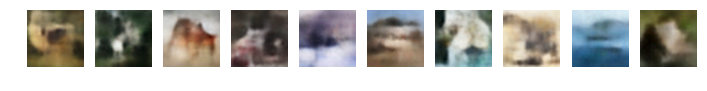

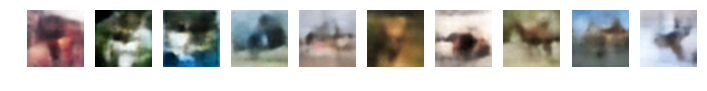

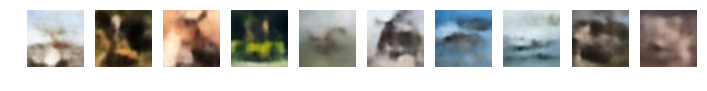

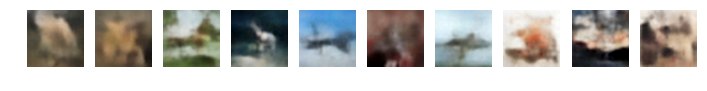

In [23]:
for label in range(10):
    show_images(wae.generate_samples(10))
    plt.show()

**Tangent prop**

In [24]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
            X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.sample_latent(X_gen) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = torch.normal(
                std=torch.ones(batch_size, latent_dim, device=device)
            ).requires_grad_() # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = X.to(device)
            z_inferred = generative_model.sample_latent(X).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [25]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [27]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [ ]:
num_epochs = 200
save_every = 10

modes = ['stochastic_manifold_reg_on_train_data__eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes[1:]:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    model = ModelConvolutional(input_shape, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
    
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_loss_full = 0
        cum_acc = 0
        batch_count = 0

        model.train()
        train_iter_unlabelled = iter(train_loader_unlabelled)
        for X, y in train_loader_labelled:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.item()
        
            loss_constrain = constrain_loss_function(
                model, wae, reparam_invariant=True, use_all_classes=False, batch_gen=train_iter_unlabelled
            )
            cum_loss_constrain += loss_constrain.item()
        
            loss_full = loss_data + eta * loss_constrain
            cum_loss_full += loss_full.item()
            
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.item()
        
            optimizer.zero_grad()
            loss_full.backward()
            optimizer.step()
            batch_count += 1
            
        mean_train_loss_data = cum_loss_data / batch_count
        mean_train_loss_constrain = cum_loss_constrain / batch_count
        mean_train_loss_full = cum_loss_full / batch_count
        mean_train_acc = cum_acc / batch_count

        train_losses[mode].append(mean_train_loss_data)
        train_accs[mode].append(mean_train_acc)
        
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_acc = 0
        batch_count = 0

        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                batch_count += 1
            
        mean_test_loss_data = cum_loss_data / batch_count
        mean_test_loss_constrain = cum_loss_constrain / batch_count
        mean_test_acc = cum_acc / batch_count

        test_losses[mode].append(mean_test_loss_data)
        test_accs[mode].append(mean_test_acc)
        
        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
            )
        )
        print('train acc: {:.2f}'.format(mean_train_acc*100))
        print('test loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}'.format(
                mean_test_loss_data, mean_test_loss_constrain
            )
        )
        print('test acc: {:.2f}'.format(mean_test_acc*100))
        print()
        
        if (epoch+1) % save_every == 0:
            with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                pickle.dump(np.array(train_losses[mode]), f)
            with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                pickle.dump(np.array(test_losses[mode]), f)
            with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                pickle.dump(np.array(train_accs[mode]), f)
            with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                pickle.dump(np.array(test_accs[mode]), f)

            torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')



Mode: stochastic_manifold_reg_on_train_data__eta=1e-05
stochastic_manifold_reg_on_train_data__eta=1e-05__labelled=4000__epochs=200
eta = 1e-05

Epoch 1 of 200 took 24.64s;
train loss:
data term: 2.02, constrain term: 0.03, full: 2.02
train acc: 28.10
test loss:
data term: 2.28, constrain term: 0.00
test acc: 18.89

Epoch 2 of 200 took 24.55s;
train loss:
data term: 1.81, constrain term: 0.19, full: 1.81
train acc: 36.20
test loss:
data term: 2.30, constrain term: 0.00
test acc: 20.80

Epoch 3 of 200 took 24.56s;
train loss:
data term: 1.71, constrain term: 0.41, full: 1.71
train acc: 39.25
test loss:
data term: 1.99, constrain term: 0.00
test acc: 27.01

Epoch 4 of 200 took 24.57s;
train loss:
data term: 1.65, constrain term: 0.68, full: 1.65
train acc: 41.25
test loss:
data term: 1.90, constrain term: 0.00
test acc: 29.10

Epoch 5 of 200 took 24.63s;
train loss:
data term: 1.60, constrain term: 0.92, full: 1.60
train acc: 43.00
test loss:
data term: 1.86, constrain term: 0.00
test acc

Epoch 48 of 200 took 24.61s;
train loss:
data term: 0.55, constrain term: 45.09, full: 0.55
train acc: 83.08
test loss:
data term: 1.18, constrain term: 0.00
test acc: 60.98

Epoch 49 of 200 took 24.56s;
train loss:
data term: 0.54, constrain term: 47.93, full: 0.54
train acc: 83.22
test loss:
data term: 1.41, constrain term: 0.00
test acc: 57.88

Epoch 50 of 200 took 24.61s;
train loss:
data term: 0.52, constrain term: 51.40, full: 0.52
train acc: 83.62
test loss:
data term: 1.07, constrain term: 0.00
test acc: 63.97

Epoch 51 of 200 took 24.78s;
train loss:
data term: 0.50, constrain term: 54.26, full: 0.50
train acc: 84.60
test loss:
data term: 1.06, constrain term: 0.00
test acc: 65.38

Epoch 52 of 200 took 24.63s;
train loss:
data term: 0.48, constrain term: 55.97, full: 0.49
train acc: 85.20
test loss:
data term: 1.01, constrain term: 0.00
test acc: 65.99

Epoch 53 of 200 took 24.59s;
train loss:
data term: 0.46, constrain term: 58.28, full: 0.46
train acc: 85.45
test loss:
data 

Epoch 95 of 200 took 24.64s;
train loss:
data term: 0.12, constrain term: 199.40, full: 0.12
train acc: 97.15
test loss:
data term: 1.20, constrain term: 0.00
test acc: 66.96

Epoch 96 of 200 took 24.64s;
train loss:
data term: 0.12, constrain term: 196.75, full: 0.13
train acc: 96.83
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.02

Epoch 97 of 200 took 24.67s;
train loss:
data term: 0.12, constrain term: 198.48, full: 0.12
train acc: 96.70
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.15

Epoch 98 of 200 took 24.63s;
train loss:
data term: 0.12, constrain term: 205.27, full: 0.12
train acc: 96.70
test loss:
data term: 1.31, constrain term: 0.00
test acc: 65.28

Epoch 99 of 200 took 24.61s;
train loss:
data term: 0.11, constrain term: 210.20, full: 0.11
train acc: 97.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.66

Epoch 100 of 200 took 24.60s;
train loss:
data term: 0.11, constrain term: 211.84, full: 0.12
train acc: 97.08
test loss

Epoch 142 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 327.78, full: 0.05
train acc: 98.83
test loss:
data term: 1.29, constrain term: 0.00
test acc: 67.78

Epoch 143 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 325.80, full: 0.05
train acc: 98.95
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.86

Epoch 144 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 327.37, full: 0.05
train acc: 98.95
test loss:
data term: 1.39, constrain term: 0.00
test acc: 66.53

Epoch 145 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 330.84, full: 0.05
train acc: 98.73
test loss:
data term: 1.33, constrain term: 0.00
test acc: 66.73

Epoch 146 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 336.03, full: 0.06
train acc: 98.70
test loss:
data term: 1.39, constrain term: 0.00
test acc: 66.51

Epoch 147 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 326.38, full: 0.07
train acc: 98.30
test

Epoch 189 of 200 took 24.69s;
train loss:
data term: 0.04, constrain term: 414.99, full: 0.04
train acc: 99.05
test loss:
data term: 1.49, constrain term: 0.00
test acc: 66.94

Epoch 190 of 200 took 24.70s;
train loss:
data term: 0.05, constrain term: 400.60, full: 0.05
train acc: 98.68
test loss:
data term: 1.51, constrain term: 0.00
test acc: 66.58

Epoch 191 of 200 took 24.91s;
train loss:
data term: 0.08, constrain term: 392.49, full: 0.09
train acc: 97.23
test loss:
data term: 1.77, constrain term: 0.00
test acc: 64.31

Epoch 192 of 200 took 24.69s;
train loss:
data term: 0.05, constrain term: 392.08, full: 0.05
train acc: 98.65
test loss:
data term: 1.56, constrain term: 0.00
test acc: 64.88



In [57]:
from pandas import ewma, DataFrame

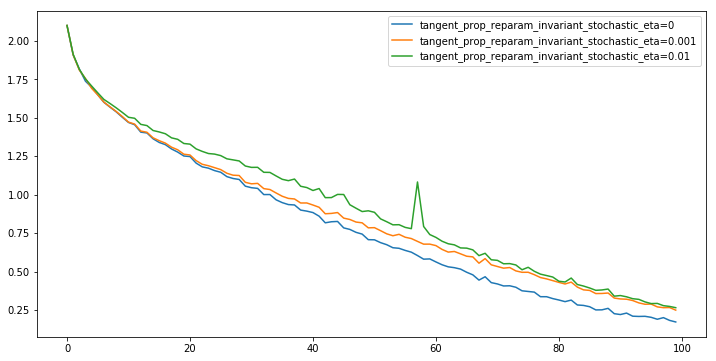

In [65]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_losses[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


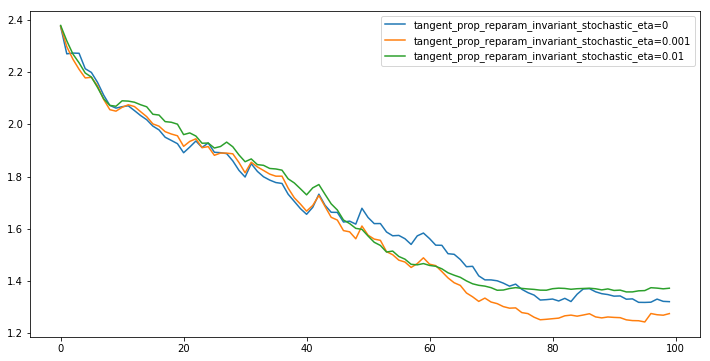

In [66]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_losses[mode]), alpha=0.1))
plt.legend(modes)

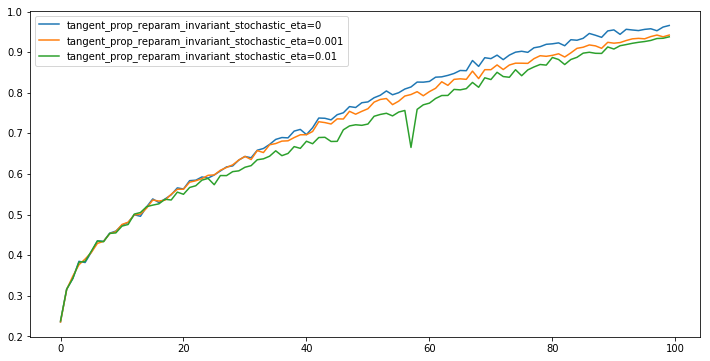

In [67]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_accs[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


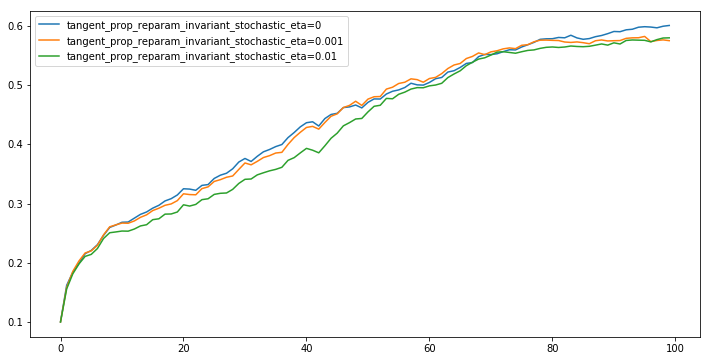

In [68]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_accs[mode]), alpha=0.1))
plt.legend(modes)